<a href="https://colab.research.google.com/github/syan1992/BSCL/blob/main/VGAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch_geometric import transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, VGAE
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
#绘图
def visualize(z):
    z=TSNE(n_components=2).fit_transform(z.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:,0], z[:,1], s=70, c=range(3327), cmap='Set2')
    plt.show()
# 导入数据
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform=T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False)
])
dataset=Planetoid('./CiteSeer', name='CiteSeer', transform=transform)
train_data, val_data, test_data=dataset[0]



Processing...
Done!


3703
epoch:1, loss:3.449901819229126, AUC:0.6921627822726724, AP:0.7103467781600513, recon_loss:3.449901819229126, kl_loss:3.041477114607005e-08
epoch:2, loss:3.472043991088867, AUC:0.6915275932858351, AP:0.7108870282459859, recon_loss:3.4720396995544434, kl_loss:4.350964445620775e-06
epoch:3, loss:3.159867525100708, AUC:0.690851346455742, AP:0.710022199747881, recon_loss:3.159849166870117, kl_loss:1.8347864170209505e-05
epoch:4, loss:3.0129621028900146, AUC:0.6894433039487984, AP:0.7093127477915788, recon_loss:3.0129175186157227, kl_loss:4.4520707888295874e-05
epoch:5, loss:2.8415584564208984, AUC:0.6887743026204566, AP:0.7088049173307179, recon_loss:2.841472625732422, kl_loss:8.582459850003943e-05
epoch:6, loss:2.744330644607544, AUC:0.688880569979471, AP:0.7089422672401356, recon_loss:2.7441859245300293, kl_loss:0.00014479081437457353
epoch:7, loss:2.5933470726013184, AUC:0.6889481946624804, AP:0.7091015196236379, recon_loss:2.5931215286254883, kl_loss:0.0002256617008242756
epoch:8,

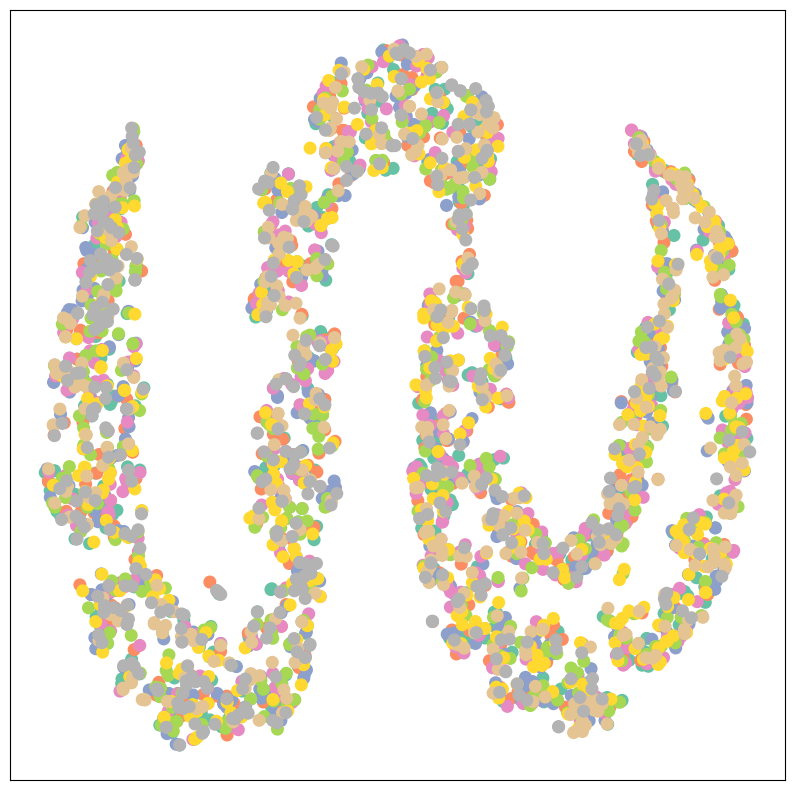

In [10]:
# 搭建encoder
class GCNencoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNencoder, self).__init__()
        self.conv1=GCNConv(in_channels, 2*out_channels)
        self.con_mu=GCNConv(2*out_channels, out_channels)
        self.con_log=GCNConv(2*out_channels, out_channels)
    def forward(self, x, edge_index):
        x=self.conv1(x, edge_index)
        x=x.relu()
        mu=self.con_mu(x, edge_index)
        log=self.con_log(x, edge_index)
        return mu, log
#搭建网络
in_channels=dataset.num_features
print(in_channels)
out_channels=16
model=VGAE(GCNencoder(in_channels, out_channels))
model = model.to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
#训练
def train():
    model.train()
    optimizer.zero_grad()
    z=model.encode(train_data.x, train_data.edge_index)
    recon_loss = model.recon_loss(z, train_data.pos_edge_label_index)
    kl_loss = 1/train_data.num_nodes*model.kl_loss()
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()
    return loss, recon_loss, kl_loss
@torch.no_grad()
def test():
    model.eval()
    z=model.encode(test_data.x, test_data.edge_index)
    AUC, AP=model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return AUC, AP
epoch=100
writer=SummaryWriter('./logs')
for i in range(epoch):
    loss, recon_loss, kl_loss = train()
    AUC, AP = test()
    writer.add_scalar('loss', loss, i)
    writer.add_scalar('AUC', AUC, i)
    writer.add_scalar('AP', AP, i)
    print('epoch:{}, loss:{}, AUC:{}, AP:{}, recon_loss:{}, kl_loss:{}'.format(i+1, loss, AUC, AP, recon_loss, kl_loss))
writer.close()
# 绘图
z=model.encode(train_data.x, train_data.edge_index)
visualize(z)